In [1]:
!pip install git+https://github.com/edwatson36/image-processing.git

  Cloning https://github.com/edwatson36/image-processing.git to /tmp/pip-req-build-d2oeku29
  Running command git clone --filter=blob:none --quiet https://github.com/edwatson36/image-processing.git /tmp/pip-req-build-d2oeku29
  Resolved https://github.com/edwatson36/image-processing.git to commit a13f6a1896796cabedfb948f299420decdffdd44
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for image-preprocessing: filename=image_preprocessing-0.1.0-py3-none-any.whl size=10312 sha256=68ebf54e329277304ba62d73e346004ffc7b1dfc8e4e80a709bd20d9ba819c6c
  Stored in directory: /tmp/pip-ephem-wheel-cache-1fu1m08u/wheels/61/e4/e0/cc1a7579b0d95ed94ca18b3a620d7d08f5c2f2926e6e3c5936
Successfully built image-preprocessing


In [2]:
import cub200_utils
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2

In [3]:
data_dir = Path("/content/sample_data")

In [4]:
# Run download and extract data
archive = cub200_utils.download_dataset(data_dir)
dataset_path = cub200_utils.extract_dataset(archive)

Download complete.
Extracting /content/sample_data/CUB_200_2011.tgz...
Extraction complete.


Randomly selected species: 199.Winter_Wren


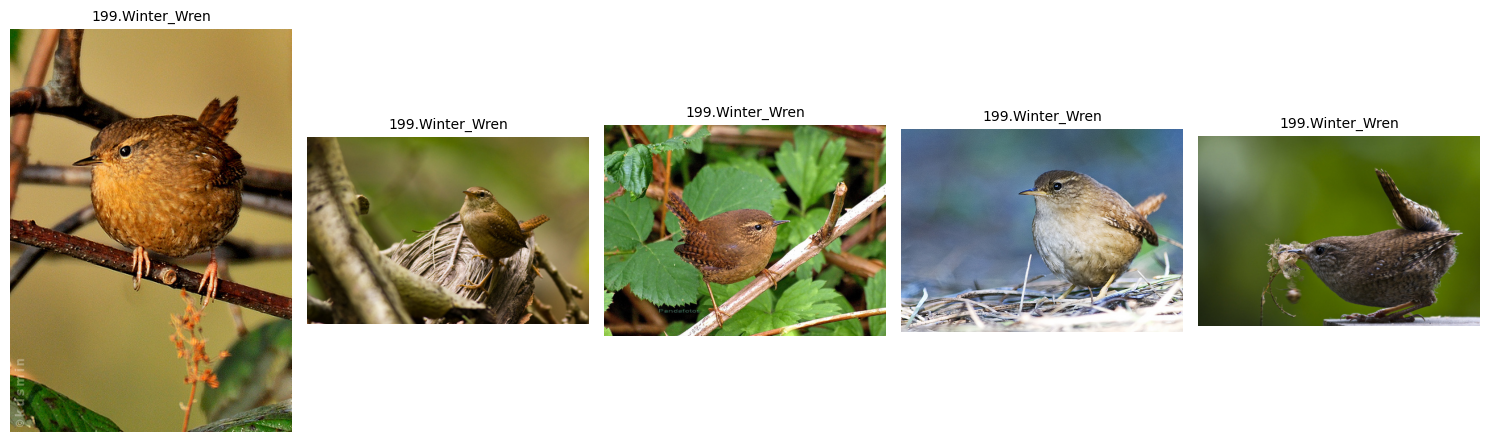

In [5]:
# Choose random species folder and plot images
image_dir = dataset_path / "images"

image_paths = cub200_utils.fetch_sample_images(image_dir, n=5)

cub200_utils.plot_sample_images(image_paths)

In [6]:
# Create official train-test split
# train-test split and core metadata are all in the main CUB_200_2011 folder
train_df, test_df = cub200_utils.create_test_split(dataset_path)
train_df.head()

Loaded images.txt, image_class_labels.txt, classes.txt with 11788, 11788, and 200 entries respectively
Loaded split file train_test_split.txt with 11788 entries
Merged metadata: 11788 rows, 5 columns -> ['image_id', 'image_path', 'class_id', 'class_name', 'is_training']
Total images: 11788
Train: 5994 | Test: 5794 | Train_Classes: 200| Test_Classes: 200


,image_id,image_path,class_id,class_name,is_training
0,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1
1,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1
2,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1
3,7,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1
4,8,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1


In [7]:
# Create validation split
train_sub_df, val_sub_df = cub200_utils.create_validation_split(train_df, val_fraction=0.2)

Training subset: 4795 images, 200 classes
Validation subset: 1199 images, 200 classes


In [8]:
# Call check_no_overlap
cub200_utils.check_no_overlap(train_sub_df, val_sub_df, test_df)

No overlapping image_ids between train, validation, and test sets.


In [9]:
# Call plot class balance
cub200_utils.plot_class_balance({
    "train": train_sub_df,
    "val": val_sub_df,
    "test": test_df
})

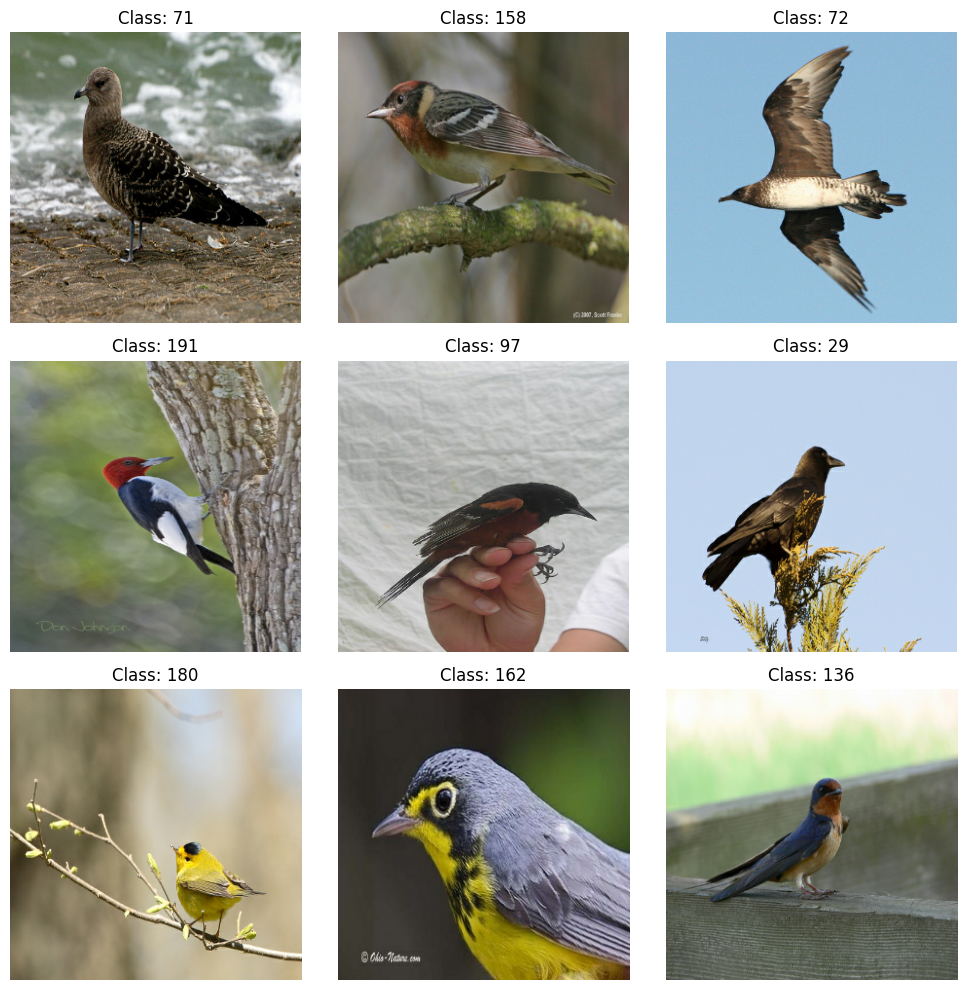

In [10]:
# Call tf.Dataset creation and view images to check
image_size = (299, 299)

# Create tf.Datasets
exmpl_train_ds, exmpl_val_ds, exmpl_test_ds = cub200_utils.create_tf_datasets(train_sub_df, val_sub_df, test_df, image_dir, image_size = image_size, batch_size = 32, inc_res_v2 = False, one_hot = False)

# Visualize one batch
cub200_utils.show_batch(exmpl_train_ds, n=9)

In [11]:
# Create tf.Dataset object for use in model (label is one hot encoded)
train_ds, val_ds, test_ds = cub200_utils.create_tf_datasets(train_sub_df, val_sub_df, test_df, image_dir, image_size = image_size, batch_size = 32, inc_res_v2 = True, one_hot = True)

In [12]:
# Apply spatial augmentations
seed_val = 42

# Define rotation and zoom parameters
rotation = 0.33 # set using evidence from EDA on Bounding Box Orientation angle (33 degrees means that the mean orientation of 41 can potentially be rotated to the max/min angles of 13/74)
zoom = [-0.64, 0] # set after Szegedy et al. 2015 - their cropping regime crops images to between 13% and 36% of input image size therefore 0.64 lower bound. They also keep the original images therefore 1 upper bound (no zooming out, only in).

# Define augmentation layers with flip, rotation, zoom (seeded)
aug_frz = tf.keras.Sequential([
    layers.RandomFlip("horizontal", seed = seed_val),
    layers.RandomRotation(factor = rotation, fill_mode = 'nearest', seed = seed_val),
    layers.RandomZoom(height_factor = zoom, fill_mode = 'nearest', seed = seed_val)
])

# Define augmentation layers with flip and rotation (seeded)
aug_fr = tf.keras.Sequential([
    layers.RandomFlip("horizontal", seed = seed_val),
    layers.RandomRotation(factor = rotation, fill_mode = 'nearest', seed = seed_val)
])

# Define augmentation layers with flip only (seeded)
aug_f = tf.keras.Sequential([
    layers.RandomFlip("horizontal", seed = seed_val),
])

In [13]:
# Define model
num_classes = 200

# Define input
inputs = tf.keras.Input(shape=(image_size[0], image_size[1], 3))

# Apply augmentations (only active during training)
x = aug_frz(inputs)

# Load base model
base_model = InceptionResNetV2(weights="imagenet", include_top=False)
base_model.trainable = False  # freeze base layers

# Connect base model
x = base_model(x, training=False)  # ensures batch norm layers stay in inference mode

# Add pooling + prediction
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

# Create model
model = Model(inputs, outputs)

# Compile
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
# Fit model
model.fit(train_ds, validation_data=val_ds, epochs=1) # 1 epoch for testing only

150/150 ━━━━━━━━━━━━━━━━━━━━ 114s 511ms/step - accuracy: 0.0586 - loss: 5.0575 - val_accuracy: 0.1985 - val_loss: 3.3661
